C:\Users\akbar\anaconda3\Lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 1024 is greater than input length  = 512, using nperseg = 512
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


Fitting 3 folds for each of 162 candidates, totalling 486 fits
Fitting 3 folds for each of 12 candidates, totalling 36 fits
Fitting 3 folds for each of 54 candidates, totalling 162 fits
Fitting 3 folds for each of 108 candidates, totalling 324 fits

Random Forest Accuracy: 0.8166666666666667
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.80      0.82       370
           1       0.80      0.83      0.82       350

    accuracy                           0.82       720
   macro avg       0.82      0.82      0.82       720
weighted avg       0.82      0.82      0.82       720


SVM Accuracy: 0.7305555555555555
SVM Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.64      0.71       370
           1       0.69      0.82      0.75       350

    accuracy                           0.73       720
   macro avg       0.74      0.73      0.73       720
weighted

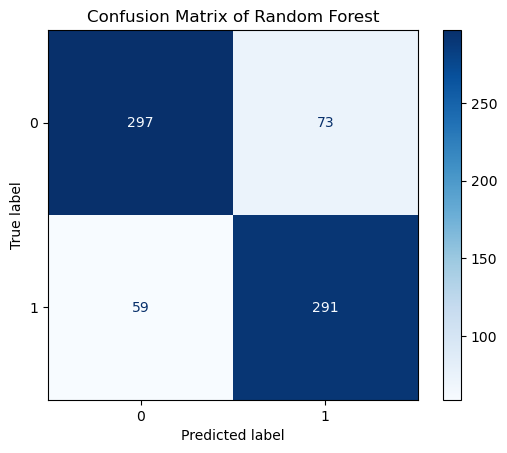

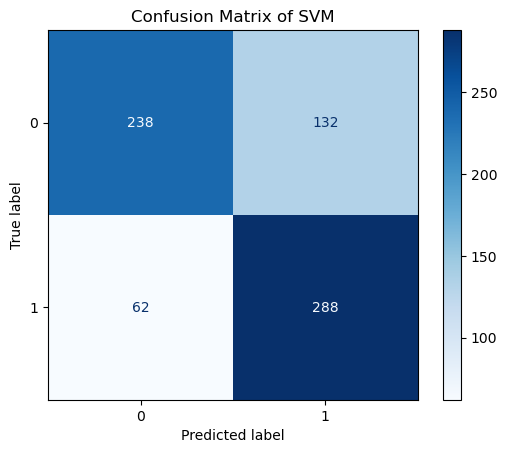

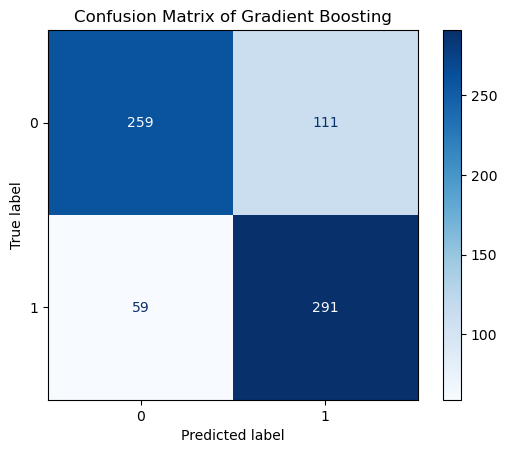

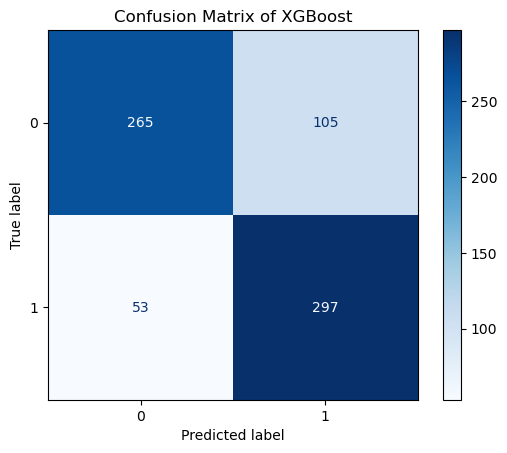

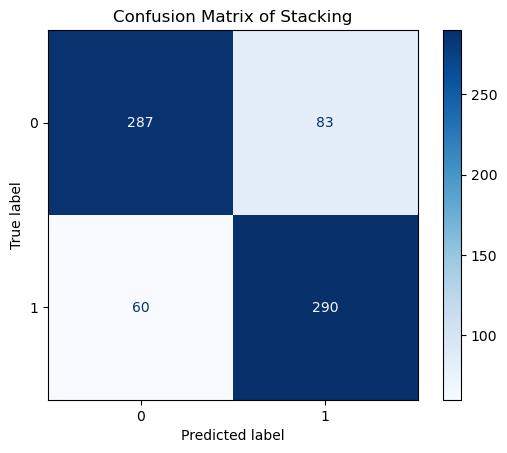

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from scipy import signal
from scipy import stats
from scipy.signal import coherence, welch
import xgboost as xgb

# Load the data
df = pd.read_csv("dataset.csv")
df.drop("time", axis=1, inplace=True)

data = df["fp1"]
labels = df["label"]
sampling_rate = 512
notch_freq = 50.0
lowcut, highcut = 0.5, 30.0
nyquist = 0.5 * sampling_rate

# Create filters
b_notch, a_notch = signal.iirnotch(notch_freq/nyquist, Q=30)
b_bandpass, a_bandpass = signal.butter(4, [lowcut/nyquist, highcut/nyquist], btype="band")
b_high, a_high = signal.butter(4, lowcut/nyquist, btype="high")
b_low, a_low = signal.butter(4, highcut/nyquist, btype="low")

# Hjorth parameter functions
def hjorth_parameters(signal):
    first_derivative = np.diff(signal)
    second_derivative = np.diff(first_derivative)
    activity = np.var(signal)
    mobility = np.sqrt(np.var(first_derivative) / activity)
    complexity = np.sqrt(np.var(second_derivative) / np.var(first_derivative))
    return activity, mobility, complexity

# Feature extraction function
def calculate_features(segment, sampling_rate):
    mean_value = np.mean(segment)
    variance = np.var(segment)
    skewness = stats.skew(segment)
    kurtosis = stats.kurtosis(segment)

    # Slope features
    slope = np.diff(segment)
    mean_slope = np.mean(slope)
    std_slope = np.std(slope)
    max_slope = np.max(np.abs(slope))

    # Zero Crossing Rate
    zero_crossings = np.where(np.diff(np.sign(segment)))[0]
    zero_crossing_rate = len(zero_crossings) / len(segment)

    # Frequency domain features using FFT
    n = len(segment)
    freqs = np.fft.fftfreq(n, d=1/sampling_rate)
    fft_values = np.abs(np.fft.fft(segment)[:n // 2])
    freqs = freqs[:n // 2]

    def band_power(freq_range):
        band_indices = np.where((freqs >= freq_range[0]) & (freqs <= freq_range[1]))
        return np.sum(fft_values[band_indices])

    delta_power = band_power((0.5, 4))
    theta_power = band_power((4, 8))
    alpha_power = band_power((8, 13))
    beta_power = band_power((13, 30))
    gamma_power = band_power((30, 40))

    spectral_centroid = np.sum(freqs * fft_values) / np.sum(fft_values)
    spectral_bandwidth = np.sqrt(np.sum((freqs - spectral_centroid) ** 2 * fft_values) / np.sum(fft_values))

    activity, mobility, complexity = hjorth_parameters(segment)

    # Power Spectral Density using Welch's method
    f, psd = welch(segment, fs=sampling_rate, nperseg=1024)
    psd_mean = np.mean(psd)
    psd_bandwidth = np.sum((f - np.mean(f))**2 * psd) / np.sum(psd)

    # Frequency Peaks (take the first peak or summarize)
    peaks, _ = signal.find_peaks(psd)
    peak_freqs = f[peaks][:5]  # top 5 peaks
    peak_psd = psd[peaks][:5]  # top 5 peaks power

    # Spectral Coherence between two signals (for demonstration, using same signal as second signal)
    _, coh = coherence(segment, segment, fs=sampling_rate, nperseg=1024)
    mean_coherence = np.mean(coh)

    # Spectral Spread (fixed with correct slicing)
    spectral_spread = np.sqrt(np.sum((f[:len(fft_values)] - spectral_centroid)**2 * fft_values) / np.sum(fft_values))

    # Return only scalar values
    return {
        'mean': mean_value,
        'variance': variance,
        'skewness': skewness,
        'kurtosis': kurtosis,
        'alpha_power': alpha_power,
        'beta_power': beta_power,
        'gamma_power': gamma_power,
        'mean_slope': mean_slope,
        'std_slope': std_slope,
        'max_slope': max_slope,
        'zero_crossing_rate': zero_crossing_rate,
        'activity': activity,
        'mobility': mobility,
        'complexity': complexity,
        'psd_mean': psd_mean,
        'psd_bandwidth': psd_bandwidth,
        'peak_freqs_mean': np.mean(peak_freqs),  # Take the mean of top 5 peaks
        'peak_psd_mean': np.mean(peak_psd),      # Take the mean of top 5 peaks power
        'mean_coherence': mean_coherence,
        'spectral_centroid': spectral_centroid,
        'spectral_spread': spectral_spread,
    }

# Sliding window for feature extraction
window_size = 512
step_size = 256
features = []
labels_new = []

for i in range(0, len(data) - window_size, step_size):
    segment = data.iloc[i:i+window_size]
    segment = pd.to_numeric(segment, errors='coerce')
    segment = signal.filtfilt(b_notch, a_notch, segment)
    segment = signal.filtfilt(b_bandpass, a_bandpass, segment)
    segment = signal.filtfilt(b_high, a_high, segment)
    segment = signal.filtfilt(b_low, a_low, segment)
    features.append(calculate_features(segment, sampling_rate))
    labels_new.append(labels.iloc[i])

# Convert features to DataFrame
features_df = pd.DataFrame(features)
features_df["label"] = labels_new
X = features_df.drop("label", axis=1)
y = features_df["label"]

# Scaling and SMOTE
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# PCA
pca = PCA(n_components=20, random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Hyperparameter tuning for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=42), rf_param_grid, cv=3, n_jobs=-1, verbose=2)
rf_grid_search.fit(X_train_pca, y_train)
rf_model = rf_grid_search.best_estimator_

# Hyperparameter tuning for SVM
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
svm_grid_search = GridSearchCV(SVC(random_state=42), svm_param_grid, cv=3, n_jobs=-1, verbose=2)
svm_grid_search.fit(X_train_pca, y_train)
svm_model = svm_grid_search.best_estimator_

# Hyperparameter tuning for Gradient Boosting
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0]
}
gb_grid_search = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_param_grid, cv=3, n_jobs=-1, verbose=2)
gb_grid_search.fit(X_train_pca, y_train)
gb_model = gb_grid_search.best_estimator_

# Hyperparameter tuning for XGBoost
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}
xgb_grid_search = GridSearchCV(xgb.XGBClassifier(random_state=42), xgb_param_grid, cv=3, n_jobs=-1, verbose=2)
xgb_grid_search.fit(X_train_pca, y_train)
xgb_model = xgb_grid_search.best_estimator_

# Stacking classifier
stacking_clf = StackingClassifier(
    estimators=[('rf', rf_model), ('svm', svm_model), ('gb', gb_model), ('xgb', xgb_model)],
    final_estimator=LogisticRegression()
)
stacking_clf.fit(X_train_pca, y_train)

# Evaluation on test data
for model, name in zip([rf_model, svm_model, gb_model, xgb_model, stacking_clf],
                       ['Random Forest', 'SVM', 'Gradient Boosting', 'XGBoost', 'Stacking']):
    y_pred = model.predict(X_test_pca)
    print(f"\n{name} Accuracy:", accuracy_score(y_test, y_pred))
    print(f"{name} Classification Report:\n", classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix of {name}")
plt.show()

In [15]:
import tkinter as tk

def show_popup(text):
    # Create a new top-level window
    popup = tk.Tk()
    popup.overrideredirect(True)  # Remove window decorations
    popup.attributes('-topmost', True)  # Keep the window on top

    # Set dimensions and center the popup
    width, height = 320, 120  # Width and height of the popup
    screen_width = popup.winfo_screenwidth()
    screen_height = popup.winfo_screenheight()
    x_offset = (screen_width // 2) - (width // 2)
    y_offset = (screen_height // 2) - (height // 2)
    popup.geometry(f"{width}x{height}+{x_offset}+{y_offset}")

    # Create a frame with borders
    border_color = "black"  # Border color
    border_width = 5  # Border width
    frame = tk.Frame(popup, bg=border_color, bd=border_width)
    frame.pack(expand=True, fill="both", padx=2, pady=2)  # Padding around the frame

    # Add label with text inside the frame
    label = tk.Label(frame, text=text, font=("Arial", 14), bg="white", fg="black")
    label.pack(expand=True, fill="both")

    # Automatically close the popup after 3 seconds
    popup.after(3000, popup.destroy)

    popup.mainloop()

In [57]:
# Taking new test data for prediction
new_test_data = pd.read_csv("test.csv")
new_test_data.columns = ["fp1"]

# Preprocess new test data
new_data = new_test_data["fp1"]
features_test = []
for i in range(0, len(new_data) - window_size, step_size):
    segment = new_data.iloc[i:i+window_size]
    segment = pd.to_numeric(segment, errors='coerce')
    segment = signal.filtfilt(b_notch, a_notch, segment)
    segment = signal.filtfilt(b_bandpass, a_bandpass, segment)
    segment = signal.filtfilt(b_high, a_high, segment)
    segment = signal.filtfilt(b_low, a_low, segment)
    features_test.append(calculate_features(segment, sampling_rate))

# Convert features to DataFrame and scale
features_test_df = pd.DataFrame(features_test)
X_test_scaled = scaler.transform(features_test_df)
X_test_pca = pca.transform(X_test_scaled)

# Predict using the trained stacking model
new_predictions = stacking_clf.predict(X_test_pca)

relaxed = sum(new_predictions)
stressed = len(new_predictions) - sum(new_predictions)

text = "Neutral"
if relaxed > 2*stressed:
    text = "Relaxed"
elif stressed > 2*relaxed:
    text = "Stressed" 
print(text)

show_popup(text)

C:\Users\akbar\anaconda3\Lib\site-packages\scipy\signal\_spectral_py.py:600: UserWarning: nperseg = 1024 is greater than input length  = 512, using nperseg = 512
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


Stressed


In [58]:
new_predictions

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)